In [1]:
import pickle
from brokenaxes import brokenaxes
import numpy as np
import pandas as pd
import itertools as it
from pathlib import Path
import matplotlib.pylab as plt
from lameg.util import get_files, make_directory, check_many
import nibabel as nib
from scipy.spatial.distance import euclidean
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import Normalize, TwoSlopeNorm
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec
from copy import copy

In [2]:
n_layers = 11
layers = np.arange(n_layers)
vx_loc, vx_adj, surf_norm = nib.load(Path("/home/common/bonaiuto/cued_action_meg/derivatives/processed/sub-001/surf/multilayer.11.ds.link_vector.fixed.gii")).agg_data()
layers_loc = np.array(np.split(vx_loc, n_layers, axis=0))
cortical_thickness = np.array([euclidean(layers_loc[0, i, :], layers_loc[-1, i, :]) for i in range(layers_loc.shape[1])])

In [3]:
snr_res = Path("../output/snr_simulations/")
snr_files = get_files(snr_res, "*.pickle")

In [4]:
def annotate_mx(im, txt_mx, **textkw):
    kw = dict(
        horizontalalignment="center",
        verticalalignment="center"
    )
    kw.update(textkw)
    for r, c in it.product(range(txt_mx.shape[0]), range(txt_mx.shape[1])):
        im.axes.text(r, c, txt_mx[r, c], **kw)

def colorbar(mappable, label):
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax, label=label)
    plt.sca(last_axes)
    return cbar


def plot_mx(mx, LAB, title="", ax=False, labels=False, cbar=False, cmap="Spectral_r", norm=False, cbar_label=r"$\Delta$ FE"):
    if not ax:
        f, ax = plt.subplots(1, 1)
    else:
        ax = ax
    if not norm:
        iw = ax.imshow(mx.T, cmap=cmap)
    else:
        iw = ax.imshow(mx.T, cmap=cmap, norm=norm)
    if labels:
        ax.set_ylabel("Evaluation Layer")
        ax.set_xlabel("Simulation Layer")
        ax.set_xticks(np.arange(11).astype(int))
        ax.set_xticklabels(LAB)
        ax.set_yticks(np.arange(11).astype(int))
        ax.set_yticklabels(LAB)
        plt.suptitle(title)
        plt.tight_layout()
    if cbar:
        colorbar(iw, cbar_label)
    return iw


def norm_res(mx):
    norm = np.zeros(mx.shape)
    for l in range(mx.shape[0]):
        normed = mx[l,:] - np.min(mx[l,:])
        norm[l,:] = normed
    return norm


def find_peaks(mx, marker="*", return_annot=True):
    annot = np.zeros(mx.shape).astype(np.object_)
    peaks = []
    for l in range(mx.shape[0]):
        peak = np.argmax(mx[l, :]) # here is the problem (you find peak in evaluated!)
        annot[l, peak] = 1.0
        peaks.append(peak)
    peaks = np.array(peaks)
    annot_bin = np.copy(annot).astype(float)
    annot[annot==0.0] = None
    annot[annot==1.0] = marker
    if return_annot:
        return peaks, annot, annot_bin
    else:
        return peaks

    
def normalize(x):
    maxx, minx = max(x), min(x)
    max_minus_min = maxx - minx
    return np.array([(elt - minx) / max_minus_min for elt in x])


def bootstrap_func(data, n_boot=1000, prop=0.5, func="mean"):
    n_rows = data.shape[0]
    rows = np.arange(n_rows)
    prop_rows = int(n_rows*prop)
    results = []
    for b in range(n_boot):
        boot_rows = np.random.choice(rows, size=prop_rows)
        if func == "mean":
            results.append(data[boot_rows].mean(axis=0))
        elif func == "sem":
            results.append(data[boot_rows].std(axis=0) / np.sqrt(prop_rows))
    return np.array(results)

def bootstrap(data, n_boot=1000, prop=0.5):
    n_rows = data.shape[0]
    rows = np.arange(n_rows)
    prop_rows = int(n_rows*prop)
    results = []
    for b in range(n_boot):
        boot_rows = np.random.choice(rows, size=prop_rows)
        results.append(data[boot_rows])
    return np.array(results)

def shuffled_peak_error(mx, ab=False):
    mx_sh = shuffle_mx(mx)
    peaks = find_peaks(mx_sh, return_annot=False)
    peaks = peaks - np.arange(mx.shape[0])
    if not ab:
        return peaks
    else:
        return np.abs(peaks)


def shuffle_mx(mx):
    mx_shape = mx.shape
    mx = mx.flatten()
    np.random.shuffle(mx)
    return mx.reshape(mx_shape)

In [5]:
fnms = np.array([[i] + i.stem.split("_") for i in snr_files])
map_fnms = np.array([i in [1, 3, 5, 6] for i in range(7)])
fnms = fnms[:,~map_fnms]
names_ = ["filename", "vx", "snr"]
df_files = pd.DataFrame.from_dict(
    {k: fnms[:,i] for i, k in enumerate(names_)}
)
df_files["matrix"] = None
df_files.vx = df_files.vx.apply(lambda x: eval(x))
df_files.snr = df_files.snr.apply(lambda x: eval(x))
mxs = []
for ix, row in df_files.iterrows():
    with open(row.filename, "rb") as file:
        output = pickle.load(file)
    output = output["layerF"]
    df_files.at[ix, "matrix"] = output

In [6]:
vertices = df_files.vx.unique()
vertices.sort()
snrs = df_files.snr.unique()
snrs.sort()

n_layers = 11
layers = np.arange(n_layers).astype(int)
LAB = list(layers)
LAB[0] = "P"
LAB[-1] = "W"

In [7]:
matrices_all = {i: [] for i in snrs}
peaks_all = {i: [] for i in snrs}
annots_bin = {i: [] for i in snrs}

for vx in vertices:
    for snr_ix, snr in enumerate(snrs):
        row = df_files.loc[
            (df_files.vx == vx) &
            (df_files.snr == snr)
        ]
        mx = row.matrix.values[0]
        mx = norm_res(mx)
        peaks, annot, annot_bin = find_peaks(mx, marker=r"$\wedge$")
        
        matrices_all[snr].append(mx)
        peaks_all[snr].append(peaks)
        annots_bin[snr].append(annot_bin)

In [8]:
snr_res = Path("../output/snr_simulations/")
snr_files = get_files(snr_res, "*.pickle")
fnms = np.array([[i] + i.stem.split("_") for i in snr_files])
map_fnms = np.array([i in [1, 3, 5, 6] for i in range(7)])
fnms = fnms[:,~map_fnms]
names_ = ["filename", "vx", "snr"]
snr_files = pd.DataFrame.from_dict(
    {k: fnms[:,i] for i, k in enumerate(names_)}
)
snr_files["matrix"] = None
snr_files["norm_matrix"] = None
snr_files["peaks"] = None
snr_files["cortical_thickness"] = None
snr_files["error"] = None
snr_files["bias"] = None
snr_files["sum_error"] = None
snr_files["sum_error_mm"] = None
snr_files["error_mm"] = None
snr_files["bias_mm"] = None
snr_files.vx = snr_files.vx.apply(lambda x: eval(x))
snr_files.snr = snr_files.snr.apply(lambda x: eval(x))
mxs = []
for ix, row in snr_files.iterrows():
    with open(row.filename, "rb") as file:
        output = pickle.load(file)
    output = output["layerF"]
    snr_files.at[ix, "matrix"] = output
    mx = norm_res(output)
    snr_files.at[ix, "norm_matrix"] = mx
    peaks, annot, annot_bin = find_peaks(mx, marker=r"$\wedge$")
    layer_multiplier = cortical_thickness[row.vx] / n_layers
    snr_files.at[ix, "peaks"] = peaks
    snr_files.at[ix, "cortical_thickness"] = cortical_thickness[row.vx]
    snr_files.at[ix, "error"] = np.abs(layers - peaks)
    snr_files.at[ix, "bias"] = layers - peaks
    snr_files.at[ix, "error_mm"] = np.mean(np.abs(layers * layer_multiplier - peaks * layer_multiplier))
    snr_files.at[ix, "bias_mm"] = np.mean(layers * layer_multiplier - peaks * layer_multiplier)
    snr_files.at[ix, "sum_error"] = np.sum(np.abs(layers - peaks))
    snr_files.at[ix, "sum_error_mm"] = np.sum(np.abs(layers * layer_multiplier - peaks * layer_multiplier))

In [9]:
snr_range = snr_files.snr.unique()
snr_range.sort()
snr_files.columns

Index(['filename', 'vx', 'snr', 'matrix', 'norm_matrix', 'peaks',
       'cortical_thickness', 'error', 'bias', 'sum_error', 'sum_error_mm',
       'error_mm', 'bias_mm'],
      dtype='object')

In [10]:
error_lines = []
bias_lines = []
error_res = []
bias_res = []
shuf_error_res = []
shuf_bias_res = []

snr = snr_range[-1]
for snr in snr_range:
    matrices = snr_files.loc[snr_files.snr == snr].norm_matrix.values.tolist()
    bias = np.array(snr_files.loc[snr_files.snr == snr].bias.to_list())
    bias = np.mean(bias, axis=-1)
    error = np.array(snr_files.loc[snr_files.snr == snr].error.to_list())
    error = np.mean(error, axis=-1)

    bias_bs = np.mean(bootstrap(bias, n_boot=5000), axis=1)
    error_bs = np.mean(bootstrap(error, n_boot=5000), axis=1)

    shuf_error = np.array([shuffled_peak_error(i, ab=True) for i in matrices*10])
    shuf_error = np.mean(shuf_error, axis=-1)
    shuf_error_bs = np.mean(bootstrap(shuf_error, n_boot=5000), axis=1)

    shuf_bias = np.array([shuffled_peak_error(i, ab=False) for i in matrices*10])
    shuf_bias = np.mean(shuf_bias, axis=-1)
    shuf_bias_bs = np.mean(bootstrap(shuf_bias, n_boot=5000), axis=1)

    # mean 95% CI
    error_95ci = [
        np.percentile(error_bs, 2.5), 
        np.percentile(error_bs, 97.5)
    ]

    error_95ci_shuf = [
        np.percentile(shuf_error_bs, 2.5), 
        np.percentile(shuf_error_bs, 97.5)
    ]

    bias_95ci = [
        np.percentile(bias_bs, 2.5), 
        np.percentile(bias_bs, 97.5)
    ]

    bias_95ci_shuf = [
        np.percentile(shuf_bias_bs, 2.5), 
        np.percentile(shuf_bias_bs, 97.5)
    ]

    error_lines.append(error)
    bias_lines.append(bias)
    error_res.append([np.mean(error)] + error_95ci)
    bias_res.append([np.mean(bias)] + bias_95ci)
    shuf_error_res.append([np.mean(shuf_error)] + error_95ci_shuf)
    shuf_bias_res.append([np.mean(shuf_bias)] + bias_95ci_shuf)

error_lines = np.array(error_lines)
bias_lines = np.array(bias_lines)
error_res = np.array(error_res)
bias_res = np.array(bias_res)
shuf_error_res = np.array(shuf_error_res)
shuf_bias_res = np.array(shuf_bias_res)

In [11]:
error_lines_mm = []
bias_lines_mm = []
error_res_mm = []
bias_res_mm = []
shuf_error_res_mm = []
shuf_bias_res_mm = []
snr = snr_range[-1]
for snr in snr_range:
    layer_mpl = snr_files.loc[snr_files.snr == snr].cortical_thickness.to_numpy() / 11
    matrices = snr_files.loc[snr_files.snr == snr].norm_matrix.values.tolist()
    bias = np.array(snr_files.loc[snr_files.snr == snr].bias.to_list())
    bias = np.mean(bias, axis=-1) * layer_mpl
    error = np.array(snr_files.loc[snr_files.snr == snr].error.to_list())
    error = np.mean(error, axis=-1) * layer_mpl

    bias_bs = np.mean(bootstrap(bias, n_boot=5000), axis=1)
    error_bs = np.mean(bootstrap(error, n_boot=5000), axis=1)

    shuf_error = np.array([shuffled_peak_error(i, ab=True) for i in matrices*10])
    shuf_error = np.mean(shuf_error, axis=-1) * np.tile(layer_mpl, 10)
    shuf_error_bs = np.mean(bootstrap(shuf_error, n_boot=5000), axis=1)

    shuf_bias = np.array([shuffled_peak_error(i, ab=False) for i in matrices*10])
    shuf_bias = np.mean(shuf_bias, axis=-1)
    shuf_bias_bs = np.mean(bootstrap(shuf_bias, n_boot=5000), axis=1)

    # mean 95% CI
    error_95ci = [
        np.percentile(error_bs, 2.5), 
        np.percentile(error_bs, 97.5)
    ]

    error_95ci_shuf = [
        np.percentile(shuf_error_bs, 2.5), 
        np.percentile(shuf_error_bs, 97.5)
    ]

    bias_95ci = [
        np.percentile(bias_bs, 2.5), 
        np.percentile(bias_bs, 97.5)
    ]

    bias_95ci_shuf = [
        np.percentile(shuf_bias_bs, 2.5), 
        np.percentile(shuf_bias_bs, 97.5)
    ]

    error_lines_mm.append(error)
    bias_lines_mm.append(bias)
    error_res_mm.append([np.mean(error)] + error_95ci)
    bias_res_mm.append([np.mean(bias)] + bias_95ci)
    shuf_error_res_mm.append([np.mean(shuf_error)] + error_95ci_shuf)
    shuf_bias_res_mm.append([np.mean(shuf_bias)] + bias_95ci_shuf)

error_lines_mm = np.array(error_lines_mm)
bias_lines_mm = np.array(bias_lines_mm)
error_res_mm = np.array(error_res_mm)
bias_res_mm = np.array(bias_res_mm)
shuf_error_res_mm = np.array(shuf_error_res_mm)
shuf_bias_res_mm = np.array(shuf_bias_res_mm)

In [15]:
tick_labels = [f"{i}" for i in snr_range]
tick_labels[0] = r"-$\infty$"
snr_ix = np.arange(snr_range.shape[0])
snr_ix[0] = snr_ix[0] - 1

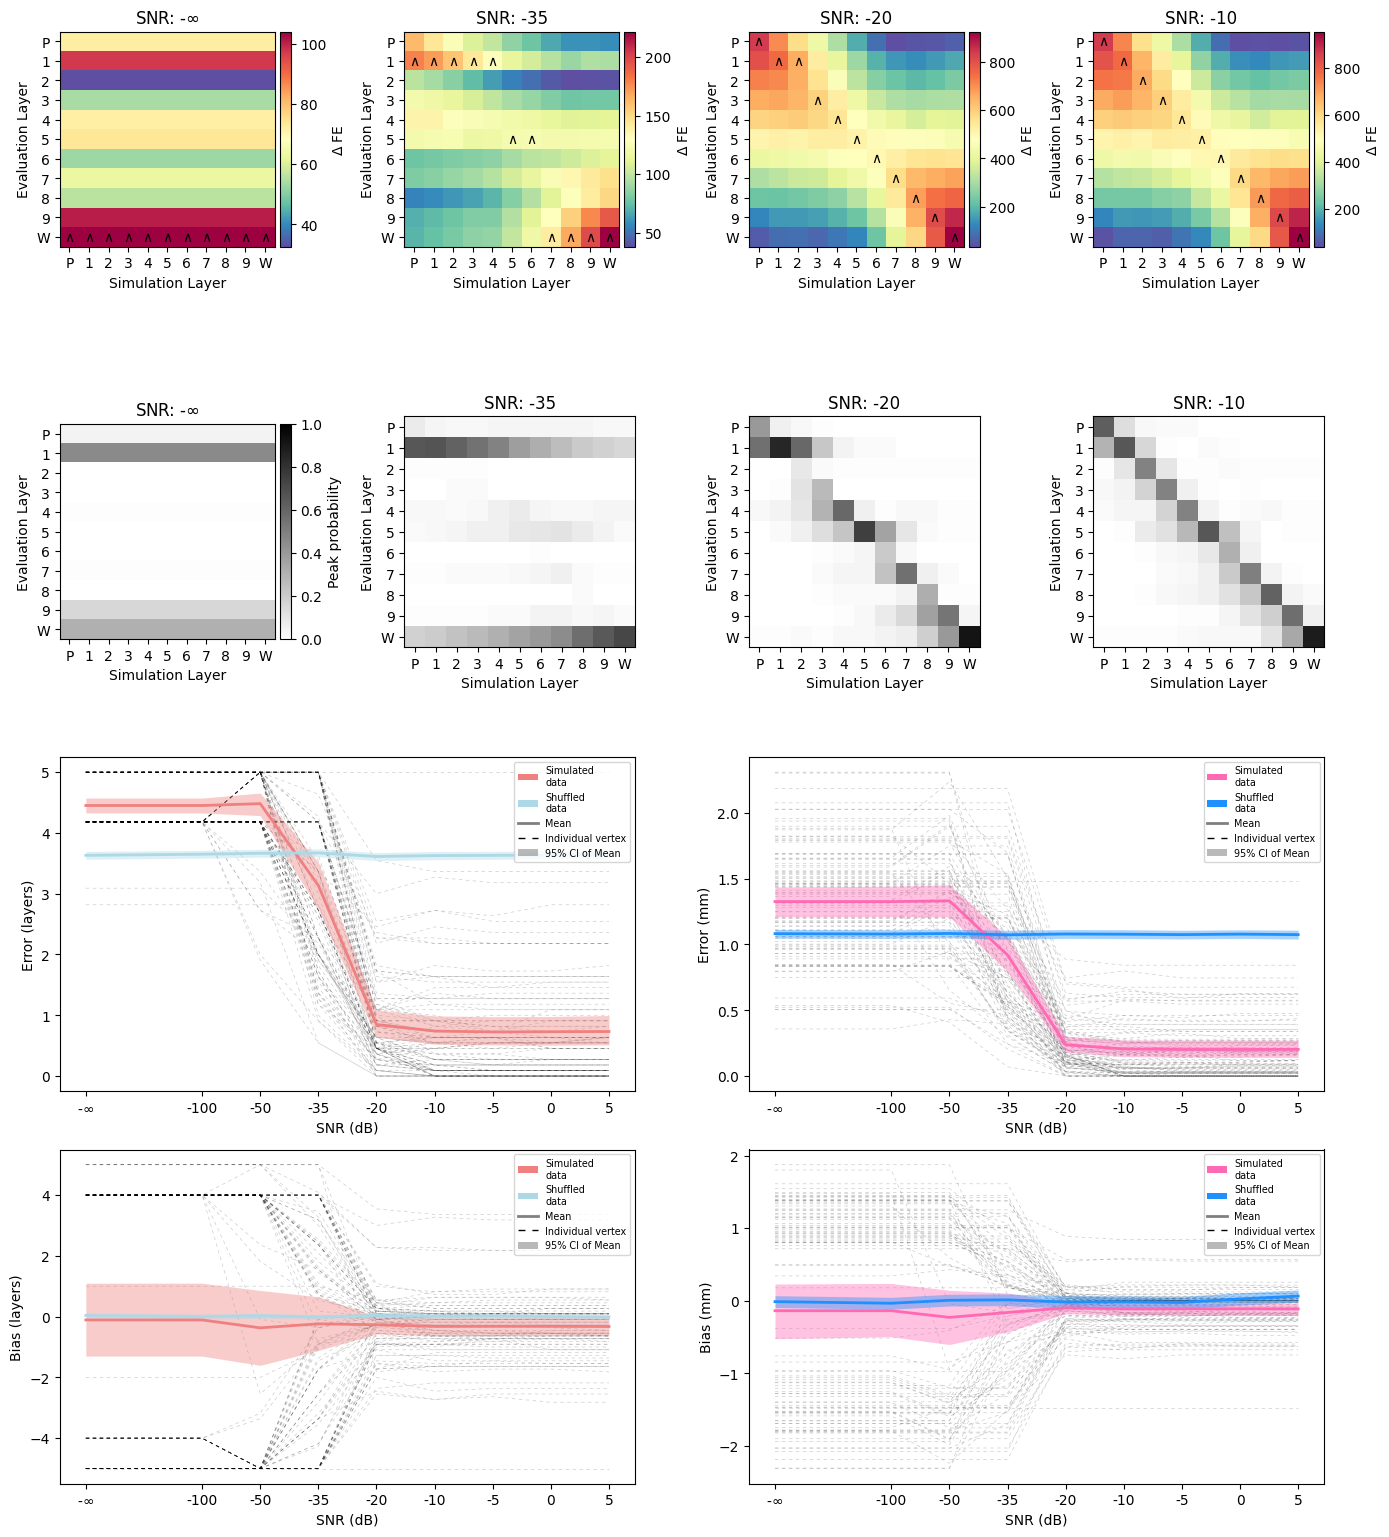

In [23]:
snrs_to_plot=[-500, -35, -20, -10]
fig=plt.figure(figsize=(3.5*len(snrs_to_plot), 16), facecolor="white")
gs = GridSpec(4, len(snrs_to_plot))
for snr_idx, snr in enumerate(snrs_to_plot):
    ax = fig.add_subplot(gs[0,snr_idx])
    if snr_idx == 0:
        ax.set_title(r"SNR: -$\infty$")
    else:
        ax.set_title(f"SNR: {snr}")
    m_mx = np.mean(matrices_all[snr], axis=0)
    peaks, annot, annot_bin = find_peaks(m_mx, marker=r"$\wedge$")
    iw = plot_mx(m_mx, LAB, ax=ax, labels=True, cbar=True, cbar_label=r"$\Delta$ FE")
    annotate_mx(iw, annot)
divnorm = Normalize(vmin=0, vmax=1)
for snr_idx, snr in enumerate(snrs_to_plot):
    ax = fig.add_subplot(gs[1,snr_idx])
    m_mx = np.mean(annots_bin[snr], axis=0)
    if snr_idx == 0:
        iw = plot_mx(m_mx, LAB, ax=ax, labels=True, cmap="binary", norm=divnorm, cbar=True, cbar_label=r"Peak probability")
        ax.set_title(r"SNR: -$\infty$")
    else:
        ax.set_title(f"SNR: {snr}")
        iw = plot_mx(m_mx, LAB, ax=ax, labels=True, cmap="binary", norm=divnorm)
        
        
ax=fig.add_subplot(gs[2,0:2])
legend_handles = [
    Patch(facecolor="lightcoral", linewidth=0, label="Simulated\ndata"),
    Patch(facecolor="lightblue", linewidth=0, label="Shuffled\ndata"),
    Line2D([0], [0], color="gray", lw=2, label="Mean"),
    Line2D([0], [0], color="black", lw=1, linestyle='--', dashes=(5, 5), label="Individual vertex"),
    Patch(facecolor="gray", linewidth=0, label="95% CI of Mean", alpha=0.55),
]
clrs = ["lightcoral", "lightblue"]
labs = ["simulated data", "shuffled data"]
for rix, r in enumerate([error_res, shuf_error_res]):
    ax.plot(snr_ix, r[:,0], color=clrs[rix], lw=2)
    ax.fill_between(snr_ix, r[:,1], r[:,2], color=clrs[rix], lw=0, alpha=0.4)
ax.set_xticks(snr_ix)
ax.set_xticklabels(tick_labels)
ax.set_ylabel("Error (layers)")
ax.set_xlabel("SNR (dB)")
ax.legend(handles=legend_handles, fontsize="x-small", loc=1)
ax.plot(snr_ix, error_lines, lw=0.5, c="black", alpha=0.2, linestyle='--', dashes=(5, 5), zorder=0);



ax=fig.add_subplot(gs[2,2:4])
legend_handles = [
    Patch(facecolor="hotpink", linewidth=0, label="Simulated\ndata"),
    Patch(facecolor="dodgerblue", linewidth=0, label="Shuffled\ndata"),
    Line2D([0], [0], color="gray", lw=2, label="Mean"),
    Line2D([0], [0], color="black", lw=1, linestyle='--', dashes=(5, 5), label="Individual vertex"),
    Patch(facecolor="gray", linewidth=0, label="95% CI of Mean", alpha=0.55),
]
clrs = ["hotpink", "dodgerblue"]
labs = ["simulated data", "shuffled data"]
for rix, r in enumerate([error_res_mm, shuf_error_res_mm]):
    ax.plot(snr_ix, r[:,0], color=clrs[rix], lw=2)
    ax.fill_between(snr_ix, r[:,1], r[:,2], color=clrs[rix], lw=0, alpha=0.4)
ax.set_xticks(snr_ix)
ax.set_xticklabels(tick_labels)
ax.set_ylabel("Error (mm)")
ax.set_xlabel("SNR (dB)")
ax.legend(handles=legend_handles, fontsize="x-small", loc=1)
ax.plot(snr_ix, error_lines_mm, lw=0.5, c="black", alpha=0.2, linestyle='--', dashes=(5, 5), zorder=0);



ax=fig.add_subplot(gs[3,0:2])
legend_handles = [
    Patch(facecolor="lightcoral", linewidth=0, label="Simulated\ndata"),
    Patch(facecolor="lightblue", linewidth=0, label="Shuffled\ndata"),
    Line2D([0], [0], color="gray", lw=2, label="Mean"),
    Line2D([0], [0], color="black", lw=1, linestyle='--', dashes=(5, 5), label="Individual vertex"),
    Patch(facecolor="gray", linewidth=0, label="95% CI of Mean", alpha=0.55),
]
clrs = ["lightcoral", "lightblue"]
labs = ["simulated data", "shuffled data"]
for rix, r in enumerate([bias_res, shuf_bias_res]):
    ax.plot(snr_ix, r[:,0], color=clrs[rix], lw=2)
    ax.fill_between(snr_ix, r[:,1], r[:,2], color=clrs[rix], lw=0, alpha=0.4)
ax.set_xticks(snr_ix)
ax.set_xticklabels(tick_labels)
ax.set_ylabel("Bias (layers)")
ax.set_xlabel("SNR (dB)")
ax.legend(handles=legend_handles, fontsize="x-small", loc=1)
ax.plot(snr_ix, bias_lines, lw=0.5, c="black", alpha=0.2, linestyle='--', dashes=(5, 5), zorder=0);



ax=fig.add_subplot(gs[3,2:4])
legend_handles = [
    Patch(facecolor="hotpink", linewidth=0, label="Simulated\ndata"),
    Patch(facecolor="dodgerblue", linewidth=0, label="Shuffled\ndata"),
    Line2D([0], [0], color="gray", lw=2, label="Mean"),
    Line2D([0], [0], color="black", lw=1, linestyle='--', dashes=(5, 5), label="Individual vertex"),
    Patch(facecolor="gray", linewidth=0, label="95% CI of Mean", alpha=0.55),
]
clrs = ["hotpink", "dodgerblue"]
labs = ["simulated data", "shuffled data"]
for rix, r in enumerate([bias_res_mm, shuf_bias_res_mm]):
    ax.plot(snr_ix, r[:,0], color=clrs[rix], lw=2)
    ax.fill_between(snr_ix, r[:,1], r[:,2], color=clrs[rix], lw=0, alpha=0.4)
ax.set_xticks(snr_ix)
ax.set_xticklabels(tick_labels)
ax.set_ylabel("Bias (mm)")
ax.set_xlabel("SNR (dB)")
ax.legend(handles=legend_handles, fontsize="x-small", loc=1)
ax.plot(snr_ix, bias_lines_mm, lw=0.5, c="black", alpha=0.2, linestyle='--', dashes=(5, 5), zorder=0);


plt.tight_layout()
#plt.savefig(output_sum.joinpath(f"snr_mean_FE.svg"))

In [43]:
snr_range

array([0, 1, 2, 3, 4, 5, 6, 7, 8])